In [ ]:
import warnings
warnings.filterwarnings("ignore")
from typing import Callable, Union

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from glob import glob
from tqdm import trange
from functools import partial

import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras import backend as K

import cv2
from PIL import Image
import albumentations as A

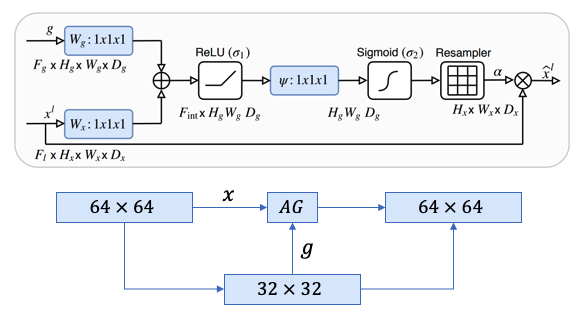

* The attention gate takes in two inputs, vectors x and g.
* The vector, g, is taken from the next lowest layer of the network. The vector has smaller dimensions and better feature representation, given that it comes from deeper into the network.
* In the example figure above, vector x would have dimensions of 64x64x64 (filters x height x width) and vector g would be 32x32x32.
* Vector x goes through a strided convolution such that it’s dimensions become 64x32x32 and vector g goes through a 1x1 convolution such that it’s dimensions become 64x32x32.
* The two vectors are summed element-wise. This process results in aligned weights becoming larger while unaligned weights become relatively smaller.
* The resultant vector goes through a ReLU activation layer and a 1x1 convolution that collapses the dimensions to 1x32x32.
* This vector goes through a sigmoid layer which scales the vector between the range [0,1], producing the attention coefficients (weights), where coefficients closer to 1 indicate more relevant features.
* The attention coefficients are upsampled to the original dimensions (64x64) of the x vector using trilinear interpolation. The attention coefficients are multiplied element-wise to the original x vector, scaling the vector according to relevance. This is then passed along in the skip connection as normal.

[Medium original article](https://towardsdatascience.com/a-detailed-explanation-of-the-attention-u-net-b371a5590831)

In [ ]:
path = r"../input/cityscapes-image-pairs/"

id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

num_classes = len(id_map.keys())

In [ ]:
labels = pd.DataFrame(data=list(id_map.values(),), index=list(id_map.keys())).reset_index()
labels.columns = ["name", "r", "g", "b"]
labels.head()
# здесь не пригодится, так как в данной версии датасета цвета в маске похоже не соответствуют официальной аннотации
# иначе можно было бы заполнить пустую маску значениями датафрейма, которые соответствуют цветной маске

In [ ]:
BATCH_SIZE = 32
INPUT_SIZE = 128
INPUT_CHANNEL = 3  # 1-grayscale, 3-RGB scale
OUTPUT_MASK_CHANNEL = num_classes  # 31 channels = 31 class per mask

FILTER_NUM = 32  # number of basic filters for the first layer
FILTER_SIZE = 3  # size of the convolutional filter
DOWN_SAMP_SIZE = 2  # size of pooling filters
UP_SAMP_SIZE = 2  # size of upsampling filters

AUTOTUNE = tf.data.AUTOTUNE
EPOCHS = 50

In [ ]:
# добавим аугментаций: важно применять их одновременно и к изображению и к маске. К сачастью модуль albumentations позволяет это легко сделать
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                    sat_shift_limit=0.2, 
                                                    val_shift_limit=0.2, 
                                                    p=0.2),      
                              A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                         contrast_limit=0.2, 
                                                         p=0.9)],p=0.2),
                              A.ToGray(p=0.05),
                      A.OneOf(
                              [A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.Transpose(p=0.5),
                              ], p=0.5),
                      # перебор
                      #A.OneOf([
                      #         A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),
                      #         A.GridDistortion(p=0.5),
                      #         A.OpticalDistortion(distort_limit=1, shift_limit=0.5, p=1),
                      #      ], p=0.8),
                      #A.Resize(height=INPUT_SIZE, width=INPUT_SIZE, p=1),
                      #A.Cutout(num_holes=8, max_h_size=10, max_w_size=10, fill_value=0, p=0.1),
                      ], p=1.0)

При разделении изображения получаем фото и трех-канальную маску, что с ней делать? Ведь хотелось бы иметь одноканальную маску, где каждая позиция соответствует классу пикселя на основном изображении.
* оставить как есть и предсказывать трех-канальное изображение как задачу регрессии (лосс: MSE, активация: logits);
* оставить как есть и предсказывать трех-канальное изображение как задачу классификации (лосс: BCE, активация pixelwise: sigmoid);
* обработать маску, получив новую с разметкой класса для каждого пикселя, решать задачу классификации (лосс SparseCategoricalCrossentropy либо Dice, активация sigmoid (softmax)) - т.е. решать классическую задачу;
* сделать one-hot кодирование маски \[batch, height, width, num_classes] и решать задачу классификации, получая на выходе сети [batch, height, width, num_classes] в виде вероятностного распределения (после активации);
* Достать метки классов с помощью кластеризации (скорее всего будет давать мелкодисперсные участки).

In [ ]:
# вариант первый: разметка через поиск расстояния (идея очень классная, но очень медленная - несколько часов предобработки)
def preprocess(path, training=False, labeling=False):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256)).resize((INPUT_SIZE, INPUT_SIZE))
    img2 = img.crop((256, 0, 512, 256)).resize((INPUT_SIZE, INPUT_SIZE))
    img1 = np.array(img1)
    img2 = np.array(img2) 
    if labeling:
        mask = np.zeros(shape=(img2.shape[0], img2.shape[1]), dtype = np.uint32)
        for row in range(img2.shape[0]):
            for col in range(img2.shape[1]):
                a = img2[row, col, :]
                final_key = final_d = None
                for key, value in id_map.items():
                    d = np.sum(np.sqrt(pow(a - value, 2)))
                    if final_key == None:
                        final_d, final_key = d, key
                    elif d < final_d:
                        final_d, final_key = d, key
                mask[row, col] = final_key
        mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1)).astype(np.uint8)
    else:
        mask = img2
    if training:
        sample = train_transforms(**{"image": img1, "mask": mask})
        img1, mask = sample["image"], sample["mask"]
    del img2
    img1 = img1 / 255.
    return img1, mask

# пока поробуем дополнительно не размечать маски
def preprocess(path):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256)).resize((INPUT_SIZE, INPUT_SIZE))
    img2 = img.crop((256, 0, 512, 256)).resize((INPUT_SIZE, INPUT_SIZE))
    img1 = np.array(img1).astype(np.float32)
    img2 = np.array(img2).astype(np.float32)
    return img1, img2

def aug_fn(image, mask):
    data = {"image":image, "mask": mask}
    aug_data = train_transforms(**data)
    aug_img = aug_data["image"]
    aug_mask = aug_data["mask"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_mask = tf.cast(aug_mask/255.0, tf.float32)  # так как маска является картинкой, а не тензором с метками классов
    return aug_img, aug_mask

def process_data(image, mask):
    aug_img, aug_mask = tf.numpy_function(func=aug_fn, inp=[image, mask], Tout=[tf.float32, tf.float32])
    return aug_img, aug_mask

def valid_aug(image, mask):
    aug_img = tf.cast(image/255.0, tf.float32)
    aug_mask = tf.cast(mask/255.0, tf.float32)
    return aug_img, aug_mask

In [ ]:
train_raw_images = glob("../input/cityscapes-image-pairs/cityscapes_data/train/*.jpg")
val_raw_images = glob("../input/cityscapes-image-pairs/cityscapes_data/val/*.jpg")

x_train_images = np.zeros((len(train_raw_images), INPUT_SIZE, INPUT_SIZE, 3), dtype=np.float32)
x_train_masks = np.zeros((len(train_raw_images), INPUT_SIZE, INPUT_SIZE, 3), dtype=np.float32)

x_valid_images = np.zeros((len(val_raw_images), INPUT_SIZE, INPUT_SIZE, 3), dtype=np.float32)
x_valid_masks = np.zeros((len(val_raw_images), INPUT_SIZE, INPUT_SIZE, 3), dtype=np.float32)

for i in trange(len(train_raw_images)):
    image, mask = preprocess(train_raw_images[i])
    x_train_images[i, ...] = image
    x_train_masks[i, ...] = mask

for i in trange(len(val_raw_images)):
    image, mask = preprocess(val_raw_images[i])
    x_valid_images[i, ...] = image
    x_valid_masks[i, ...] = mask

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train_images, x_train_masks)).map(partial(process_data), num_parallel_calls=AUTOTUNE).cache().shuffle(len(x_train_images)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid_images, x_valid_masks)).map(lambda x,y: (valid_aug(x,y))).batch(BATCH_SIZE).prefetch(AUTOTUNE)

**Сборка модели UNET с механизмом самовнимания и функции потерь**

In [ ]:
# дополнительный лосс
def multiclass_dice_loss() -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    y_true: [batch, height, width, 1]
    y_pred: [batch, height, width, num_classes]
    """
    def loss(y_true: tf.Tensor, y_pred: tf.Tensor, smooth: float = 1e-7) -> tf.Tensor:
        y_true = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)[...,1:])  # ignores 0 index
        y_pred = K.flatten(y_pred[..., 1:])

        numerator = K.sum(y_true * y_pred, axis=-1)
        denominator = K.sum(y_true + y_pred, axis=-1)
        dice_coef = K.mean((2. * (numerator + smooth) / (denominator + smooth)))

        return 1 - dice_coef

    return loss

def dice_coeff_loss(y_true, y_pred):

    def dice_coeff(y_true, y_pred, smooth=1e-7):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    
    return dice_coeff

def dice_coeff(y_true, y_pred, smooth=1e-7):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

**Модель**

In [ ]:
def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):  # basic convolutional block
    axis = 3
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(x)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=axis)(conv)
    conv = layers.Activation('relu')(conv)
    conv = layers.Conv2D(size, (filter_size, filter_size), padding='same')(conv)
    if batch_norm is True:
        conv = layers.BatchNormalization(axis=axis)(conv)
    conv = layers.Activation('relu')(conv)
    if dropout > 0:
        conv = layers.Dropout(dropout)(conv)

    shortcut = layers.Conv2D(size, kernel_size=(1, 1), padding='same')(x)
    if batch_norm is True:
        shortcut = layers.BatchNormalization(axis=axis)(shortcut)

    res_path = layers.add([shortcut, conv])
    return res_path

In [ ]:
def gating_signal(input, out_size, batch_norm=False):  # get previous prepred activation maps
    x = layers.Conv2D(out_size, (1, 1), padding='same')(input)
    if batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def expend_as(tensor, rep):  # align to channel size with repeat function
     return layers.Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                          arguments={'repnum': rep})(tensor)

def attention_block(x, gating, inter_shape):  # compute attention with g_conv(=previous) and c_conv (=current) cnn-block outputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    theta_x = layers.Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
    shape_theta_x = K.int_shape(theta_x)

    phi_g = layers.Conv2D(inter_shape, (1, 1), padding='same')(gating)
    upsample_g = layers.Conv2DTranspose(inter_shape, (3, 3),
                                 strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                 padding='same')(phi_g)  # 16

    concat_xg = layers.add([upsample_g, theta_x])
    act_xg = layers.Activation('relu')(concat_xg)
    psi = layers.Conv2D(1, (1, 1), padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)
    upsample_psi = layers.UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32

    upsample_psi = expend_as(upsample_psi, shape_x[3])

    y = layers.multiply([upsample_psi, x])

    result = layers.Conv2D(shape_x[3], (1, 1), padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn

def Attention_ResUNet(dropout_rate=0.0, batch_norm=True):  # full Attention-UNET model
    # dimension of the image depth
    inputs = layers.Input((INPUT_SIZE, INPUT_SIZE, INPUT_CHANNEL), dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = double_conv_layer(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = double_conv_layer(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = double_conv_layer(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = double_conv_layer(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = double_conv_layer(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = double_conv_layer(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = double_conv_layer(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = double_conv_layer(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = double_conv_layer(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # conv_final = layers.Conv2D(OUTPUT_MASK_CHANNEL, kernel_size=(1,1), activation="softmax")(up_conv_128) # or from_logits tr 
    # conv_final = layers.Conv2D(3, kernel_size=(1,1), activation="sigmoid")(up_conv_128)
    conv_final = layers.Conv2D(32, kernel_size=(1,1))(up_conv_128)  # OUTPUT_MASK_CHANNEL
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('relu')(conv_final)  # на самом деле сеть дает такие же или даже лучше результаты, если убрать этот блок (conv-batch-relu)
    
    conv_final = layers.Conv2D(3, kernel_size=(1,1), activation="sigmoid")(conv_final)

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [ ]:
class UpdatedMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self,
        y_true=None,
        y_pred=None,
        num_classes=None,
        name=None,
        dtype=None):
        super(UpdatedMeanIoU, self).__init__(num_classes = num_classes,name=name, dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.math.argmax(y_pred, axis=-1)
        return super().update_state(y_true, y_pred, sample_weight)
    
class VizCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def on_epoch_end(self, epoch, logs=None):
        file_path = val_raw_images[np.random.randint(len(val_raw_images))]
        img, mask = preprocess(file_path)
        img = np.array(img)[np.newaxis, ...] / 255.
        pred = model.predict(img)[0]
        # y_pred = tf.math.argmax(pred, axis=-1)  # при таргете [batch, height, width, num_classes]
        y_pred = np.array(pred)
        # y_pred = np.reshape(y_pred, (INPUT_SIZE, INPUT_SIZE))
        fig, axes = plt.subplots(nrows=1, ncols=3)
        axes[0].imshow(img.squeeze())
        axes[0].set_title("Image")
        axes[1].imshow(mask/255.)
        axes[1].set_title("Original Mask")
        axes[2].imshow(y_pred)
        axes[2].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

In [ ]:
model = Attention_ResUNet()
model.compile(optimizer="adam", loss="binary_crossentropy",)
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
             VizCallback()]
# logloss и sigmoid разымывают картинки, пропускает миноритарные классы, но в целом результат есть
# необходимо попробовать найти время и вырезать метки для таргета argmax([b, h, w, cls], axis=-1)

In [ ]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=callbacks, verbose=1)

In [ ]:
# MSE
model = Attention_ResUNet()  # sigmoid output [0,1] with [0,1] input, так, например, в GAN меняют BCE на MSE и результат лучше
model.compile(optimizer="adam", loss="mean_squared_error",)
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
             VizCallback()]

history = model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, callbacks=callbacks, verbose=1)

**Есть другое решение**

In [ ]:
# возьмем поменьше классов и найдем их метки для маски
def load_image(path):
    img = Image.open(path)
    img1 = img.crop((0, 0, 256, 256)).resize((INPUT_SIZE, INPUT_SIZE))
    img2 = img.crop((256, 0, 512, 256)).resize((INPUT_SIZE, INPUT_SIZE))
    img1 = np.array(img1)
    img2 = np.array(img2) 
    
    return img1, img2

def bin_image(mask, bins=None):
    if bins is None:
        bins = np.array([20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240])  # добавить бинов для большего количества классов
    new_mask = np.digitize(mask, bins)  # получим индексы бинов, к которым относятся полученные значения из входного массива
    return new_mask

def getSegmentationArr(image, classes, width=INPUT_SIZE, height=INPUT_SIZE, one_hot=True):
    seg_labels = np.zeros((height, width, classes))
    img = image[:, : , 0]

    for c in range(classes):
        seg_labels[:, :, c] = (img == c).astype(int)
    if one_hot:
        return seg_labels  # здесь получаем маску [h,w,cls], для экономии памяти можно возвращать np.argmax(seg_labels, axis=-1) -> [h,w,1], использовать sparse_categorical_crossentropy
    else:
        return np.argmax(seg_labels, axis=-1)

def give_color_to_seg_img(seg, n_classes=13):
    
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("husl", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

def pipeline(path, classes=13, bins=None, one_hot=True):
    image, mask = load_image(path)
    bin_mask = bin_image(mask, bins=bins)
    seg_labels = getSegmentationArr(bin_mask, classes=classes, one_hot=one_hot)
    return image / 255., seg_labels

In [ ]:
train_raw_images = glob("../input/cityscapes-image-pairs/cityscapes_data/train/*.jpg")
val_raw_images = glob("../input/cityscapes-image-pairs/cityscapes_data/val/*.jpg")

x_train_images = np.zeros((len(train_raw_images), INPUT_SIZE, INPUT_SIZE, 3), dtype=np.float32)
x_train_masks = np.zeros((len(train_raw_images), INPUT_SIZE, INPUT_SIZE, 13), dtype=np.float32)  # one_hot, иначе axis=-1 -> 1

x_valid_images = np.zeros((len(val_raw_images), INPUT_SIZE, INPUT_SIZE, 3), dtype=np.float32)
x_valid_masks = np.zeros((len(val_raw_images), INPUT_SIZE, INPUT_SIZE, 13), dtype=np.float32)  # one_hot, иначе axis=-1 -> 1

for i in trange(len(train_raw_images)):
    image, mask = pipeline(train_raw_images[i])
    x_train_images[i, ...] = image
    x_train_masks[i, ...] = mask

for i in trange(len(val_raw_images)):
    image, mask = pipeline(val_raw_images[i])
    x_valid_images[i, ...] = image
    x_valid_masks[i, ...] = mask

In [ ]:
def train_generator():
    for image, mask in zip(x_train_images, x_train_masks):
        yield image, mask
        
def valid_generator():
    for image, mask in zip(x_valid_images, x_valid_masks):
        yield image, mask

In [ ]:
train_ds = tf.data.Dataset.from_generator(train_generator, 
                                          output_shapes=((128,128,3), (128,128,13)),
                                          output_types=((tf.float32, tf.uint8))).cache().shuffle(len(x_train_images)).batch(BATCH_SIZE).prefetch(AUTOTUNE)
valid_ds = tf.data.Dataset.from_generator(valid_generator,
                                          output_shapes=((128,128,3), (128,128,13)),
                                          output_types=((tf.float32, tf.uint8))).batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [ ]:
def Attention_ResUNet(dropout_rate=0.0, batch_norm=True):  # full Attention-UNET model
    # dimension of the image depth
    inputs = layers.Input((INPUT_SIZE, INPUT_SIZE, INPUT_CHANNEL), dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = double_conv_layer(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = layers.MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = double_conv_layer(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = layers.MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = double_conv_layer(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = layers.MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = double_conv_layer(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = layers.MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = double_conv_layer(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = layers.concatenate([up_16, att_16], axis=axis)
    up_conv_16 = double_conv_layer(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = layers.concatenate([up_32, att_32], axis=axis)
    up_conv_32 = double_conv_layer(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = layers.concatenate([up_64, att_64], axis=axis)
    up_conv_64 = double_conv_layer(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = layers.UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = layers.concatenate([up_128, att_128], axis=axis)
    up_conv_128 = double_conv_layer(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    conv_final = layers.Conv2D(32, kernel_size=(1,1))(up_conv_128)  # здесь аналогично: можно для прототы убрать этот блок
    conv_final = layers.BatchNormalization(axis=axis)(conv_final)
    conv_final = layers.Activation('relu')(conv_final)
    
    conv_final = layers.Conv2D(13, kernel_size=(1,1), activation="softmax")(conv_final)

    # Model integration
    model = models.Model(inputs, conv_final, name="AttentionResUNet")
    return model

In [ ]:
def dice_coef(y_true, y_pred):
    return (2. * K.sum(y_true * y_pred) + 1.) / (K.sum(y_true) + K.sum(y_pred) + 1.)

In [ ]:
class VizCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def on_epoch_end(self, epoch, logs=None):
        file_path = val_raw_images[np.random.randint(len(val_raw_images))]
        img, mask = pipeline(file_path)
        img = np.array(img)[np.newaxis, ...]
        
        pred = model.predict(img)[0]
        y_pred = tf.math.argmax(pred, axis=-1)
        y_pred = np.array(y_pred)
        y_pred = np.reshape(y_pred, (INPUT_SIZE, INPUT_SIZE))
        y_pred = give_color_to_seg_img(y_pred)
        
        mask = give_color_to_seg_img(np.argmax(mask, axis=-1))
        img = img.squeeze()
        img = cv2.addWeighted(img, 0.5, y_pred, 0.5, 0)
        
        img = Image.fromarray((img*255).astype(np.uint8)).resize((256,256))
        mask = Image.fromarray((mask*255).astype(np.uint8)).resize((256,256))
        y_pred = Image.fromarray((y_pred*255).astype(np.uint8)).resize((256,256))
        
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,5))
        axes[0].imshow(img)
        axes[0].set_title("Image")
        axes[1].imshow(mask)
        axes[1].set_title("Original Mask")
        axes[2].imshow(y_pred)
        axes[2].set_title("Predicted Mask")
        plt.tight_layout()
        plt.show()

In [ ]:
model = Attention_ResUNet() 

model.summary()

In [ ]:
# categorcal_xe вмесо sparse_cat_xe так как input/output [b,h,w,cls] вместо [b,h,w,1] и argmax([b,h,w,cls], -1)
model.compile(optimizer="adam", loss="categorical_crossentropy", )#metrics=[UpdatedMeanIoU(num_classes=13, name = "mean_iou"),
                                                                   #       dice_coef])
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
             VizCallback()]

history = model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, 
                    callbacks=callbacks, 
                    verbose=1)

In [ ]:
# слегка модифицированная функция из https://github.com/maxvfischer/keras-image-segmentation-loss-functions/blob/master/losses/multiclass_losses.py
def multiclass_weighted_dice_loss(class_weights: Union[list, np.ndarray, tf.Tensor]) -> Callable[[tf.Tensor, tf.Tensor], tf.Tensor]:
    """
    Weighted Dice loss.
    Used as loss function for multi-class image segmentation with one-hot encoded masks.
    :param class_weights: Class weight coefficients (Union[list, np.ndarray, tf.Tensor], len=<N_CLASSES>)
    :return: Weighted Dice loss function (Callable[[tf.Tensor, tf.Tensor], tf.Tensor])
    """
    if class_weights is None:
        class_weights = tf.ones((13, ))
    if not isinstance(class_weights, tf.Tensor):
        class_weights = tf.constant(class_weights)
    class_weights = tf.cast(class_weights, dtype=tf.float32)

    def loss(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
        """
        Compute weighted Dice loss.
        :param y_true: True masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :param y_pred: Predicted masks (tf.Tensor, shape=(<BATCH_SIZE>, <IMAGE_HEIGHT>, <IMAGE_WIDTH>, <N_CLASSES>))
        :return: Weighted Dice loss (tf.Tensor, shape=(None,))
        """
        y_true = tf.cast(y_true, dtype=tf.float32)
        axis_to_reduce = range(1, K.ndim(y_pred))  # Reduce all axis but first (batch)
        numerator = y_true * y_pred * class_weights  # Broadcasting
        numerator = 2. * K.sum(numerator, axis=axis_to_reduce)

        denominator = (y_true + y_pred) * class_weights # Broadcasting
        denominator = K.sum(denominator, axis=axis_to_reduce)

        return 1 - numerator / denominator

    return loss

In [ ]:
model = Attention_ResUNet() 

model.compile(optimizer="adam", loss=multiclass_weighted_dice_loss(class_weights=None))
                                                                   
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
             VizCallback()]

history = model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, 
                    callbacks=callbacks, 
                    verbose=1)

Модель плохо справляется с мелкими объектами. Необходимо также поэкспериментировать с количеством классов.

In [ ]:
# np.product(np.argmax(x_train_masks[:-1], axis=-1).shape) / np.bincount(np.argmax(x_train_masks[:-1], axis=-1).astype("int").flatten()) 

In [ ]:
# model = Attention_ResUNet() 
# [0.13223864, 0.01291023, 0.0165035 , 0.21924963, 0.04017082,
#  0.14778805, 0.31725249, 0.01994548, 0.01002389, 0.0137434,
#  0.01081679, 0.01933819, 0.04001889]
# [7.56208634, 77.45796294, 60.59319281,  4.56101111, 24.89369172,
# 6.76644684,  3.1520635 , 50.1366611 , 99.76171523, 72.76221252,
# 92.44888333, 51.71114528, 24.98820028]
# model.compile(optimizer="adam", loss=multiclass_weighted_dice_loss(class_weights=1-np.array([0.86776136, 0.98708977, 0.9834965 , 0.78075037, 0.95982918,
#                                                                                            0.85221195, 0.68274751, 0.98005452, 0.98997611, 0.9862566 ,
#                                                                                            0.98918321, 0.98066181, 0.95998111])))
                                                                   
# callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=3),
#              tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
#              VizCallback()]

# history = model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, 
#                     callbacks=callbacks, 
#                     verbose=1)
# улучшений нет

**DeepLabV3**

https://arxiv.org/pdf/1706.05587.pdf

In [ ]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=tf.keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)

def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output

def DeeplabV3Plus(image_size, num_classes):
    model_input = tf.keras.Input(shape=(image_size, image_size, 3))
    resnet50 = tf.keras.applications.ResNet50(
        weights="imagenet", include_top=False, input_tensor=model_input  # берем предобученный backbone
    )
    # resnet50.trainable = False  # раскомментировать, если веса backbone не подлежат обновлению
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    input_a = layers.UpSampling2D(
        size=(image_size // 4 // x.shape[1], image_size // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size // x.shape[1], image_size // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same", activation="softmax")(x)
    
    return tf.keras.Model(inputs=model_input, outputs=model_output)

In [ ]:
model = DeeplabV3Plus(INPUT_SIZE, 13)
model.summary()

In [ ]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)  # если не заморозить веса backbone, то при высокой скорости обучения мы можем повредить хорошие веса
# model.compile(optimizer=optimizer, loss="categorical_crossentropy")  # [b,h,w,cls] - [b,h,w,cls], для sparse_categorical_crossentropy брать x_train argamx(-1)[b,h,w,cls] = [b,h,w,1] - экономит память
model.compile(optimizer="adam", loss=multiclass_weighted_dice_loss(class_weights=None), )
# model.compile(optimizer="adam", loss="categorical_crossentropy")
# model.compile(optimizer=optimizer, loss=multiclass_weighted_dice_loss(class_weights=None), )

callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=3),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
             VizCallback()]

history = model.fit(train_ds, epochs=EPOCHS, validation_data=valid_ds, 
                    callbacks=callbacks, 
                    verbose=1)
# ce + init_lr=0.00001 требуется много эпох (Loss постепенно снижается), >> 50
# ce + freeze resnet + init_lr=0.001 - так нормально и не обучилась
# dice + freeze + init_lr=0.001 - 

**BONUS: еще функция по отрисовке масок**

In [ ]:
def evaluate(model=model, path_list=val_raw_images):
    idx = np.random.randint(len(path_list))
    image, mask = pipeline(path_list[idx])
    
    outputs = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    outputs = np.argmax(outputs, axis=-1)

    color_seg = np.zeros((outputs.shape[0], outputs.shape[1], 3), dtype=np.uint8)
    
    for label, color in id_map.items():
        color_seg[outputs == label, :] = color
        
    #color_seg = color_seg[..., ::-1]

    img = np.clip(image*255, a_min=0, a_max=255) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)
    
    # GT
    gt_map = np.argmax(mask, axis=-1)
    #gt_map[gt_map == 0] = 255  # background
    #gt_map = gt_map - 1
    #gt_map[gt_map == 254] = 255

    color_seg = np.zeros((gt_map.shape[0], gt_map.shape[1], 3), dtype=np.uint8)
    for label, color in id_map.items():
        color_seg[gt_map == label, :] = color

    #color_seg = color_seg[..., ::-1]
    
    gt_mask = np.clip(image*255, a_min=0, a_max=255) * 0.5 + color_seg * 0.5
    gt_mask = gt_mask.astype(np.uint8)

    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Predicted Image')
    plt.imshow(img)
    
    plt.subplot(132)
    plt.title('GT segmentation mask')
    plt.imshow(gt_mask)
    
    plt.subplot(133)
    plt.title('Original Image')
    plt.imshow(image)
    
    plt.tight_layout()
    plt.show()
    plt.pause(0.01)

In [ ]:
evaluate()
# видно, конечно, что маски GT сформированы не идеально!

### [Results](https://www.kaggle.com/code/pankratozzi/tf-attention-unet-segmentation)